# Denoising Diffusion Probabilistic Models with miniai

In [7]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [8]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [9]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [10]:
dt = dls.train
xb,yb = next(iter(dt))

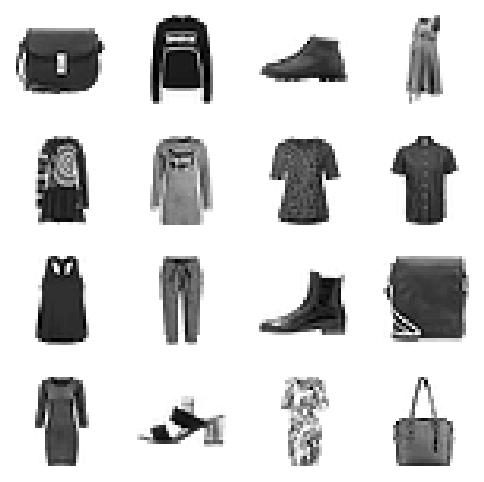

In [11]:
show_images(xb[:16], imsize=1.5)

In [15]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

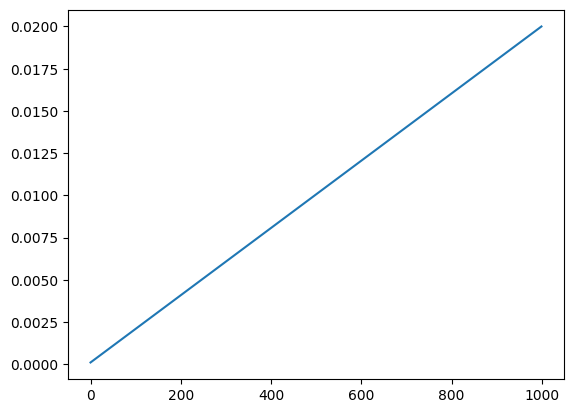

In [18]:
plt.plot(beta);

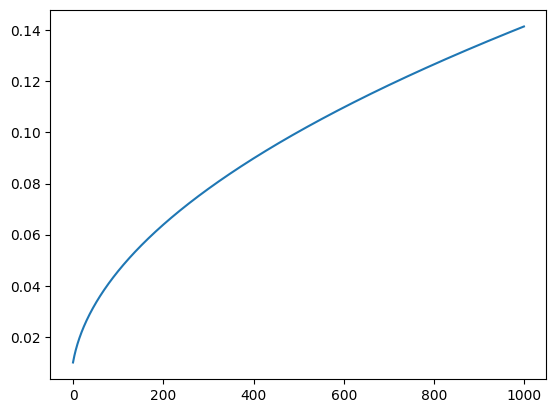

In [19]:
plt.plot(sigma);

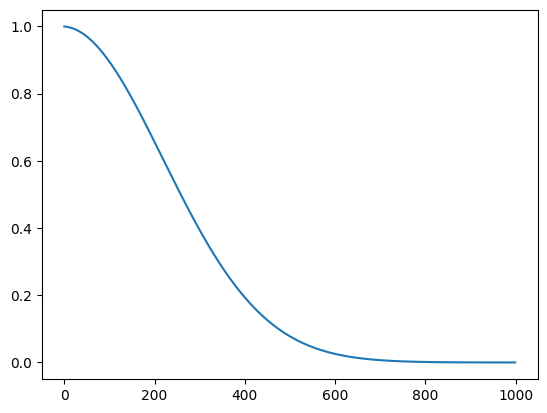

In [20]:
plt.plot(alphabar);

In [25]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt() * x0 + (1. - ᾱ_t).sqrt() * ε
    return (xt, t.to(device)), ε

In [27]:
(xt, t), ε = noisify(xb[:25], alphabar)
t

tensor([820, 291,  32,  52, 254, 928, 664, 110, 338, 835, 147, 820, 216, 958,
        145, 822, 641, 562,  61, 262, 762, 851, 866, 709, 990])

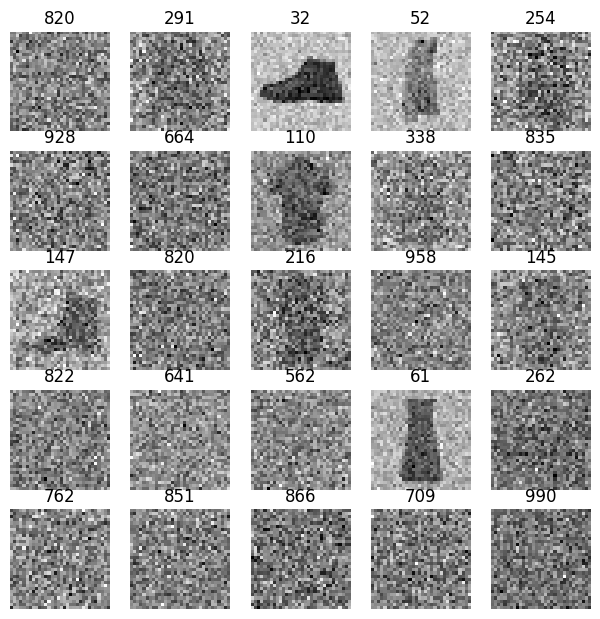

In [29]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Training

In [30]:
from diffusers import UNet2DModel

In [45]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(rand(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - alphabar[t-1]
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch))) / alphabar[t].sqrt()).clamp(-1, 1)
        x_t = x_0_hat * ᾱ_t1.sqrt() * (1 - alpha[t]) / b̄_t + x_t * alpha[t].sqrt() * b̄_t1 / b̄_t + sigma[t] * z
        preds.append(x_t.cpu())
    return preds

In [46]:
# @torch.no_grad()
# def sample(model, sz, alpha, alphabar, sigma, n_steps):
#     device = next(model.parameters()).device
#     x_t = torch.randn(sz, device=device)
#     preds = []
#     for t in reversed(range(n_steps)):
#         t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
#         z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
#         ᾱ_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
#         b̄_t = 1 - alphabar[t]
#         b̄_t1 = 1 - ᾱ_t1
#         x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch))) / alphabar[t].sqrt()).clamp(-1, 1)
#         x_t = x_0_hat * ᾱ_t1.sqrt() * (1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
#         preds.append(x_t.cpu())
#     return preds

In [47]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)


In [48]:
# TODO check the docstring is right on this
class UNet(UNet2DModel):
    """UNet that takes a tuple as input and returns a single output"""
    def forward(self, x): return super().forward(*x).sample

In [49]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

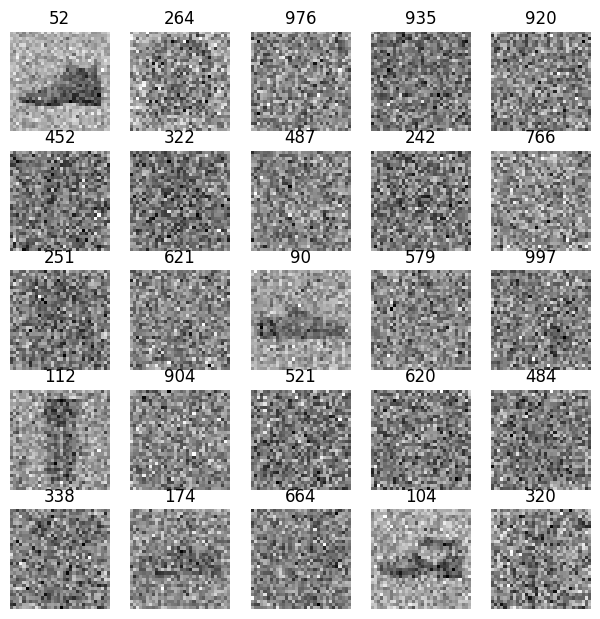

In [50]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb, SingleBatchCB()])
(xt, t), ε = learn.batch
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{}'))

In [52]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [53]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [54]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [55]:
init_ddpm(model)

In [56]:
opt_func = partial(optim.Adam, eps=1e-5)

In [57]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)